<a href="https://colab.research.google.com/github/Noelleip/Module2_note/blob/main/defaultmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import tensorflow as tf
import os
import pathlib
import cv2
import imghdr
import numpy as np
import matplotlib.pyplot as plt

BATCH_SIZE = 64
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160
MODEL_NAME="model"
UNET="unet_model"
MOBILE_NET_V2="mobilenet_v2"
LEARNING_RATE=0.01
INITIAL_EPOCHS = 100

data_dir = pathlib.Path('datasets')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

image_exts = ['jpeg','jpg','bmp','png']

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

data=tf.keras.utils.image_dataset_from_directory('datasets')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
print(batch[0])
print(data)

Found 16 files belonging to 3 classes.
[[[[2.63867188e+01 3.43867188e+01 2.13867188e+01]
   [3.62148438e+01 4.12148438e+01 3.42148438e+01]
   [3.16484375e+01 3.66484375e+01 2.96484375e+01]
   ...
   [5.78554688e+01 6.38554688e+01 5.18554688e+01]
   [5.20507812e+01 5.80507812e+01 4.60507812e+01]
   [6.38515625e+01 6.98515625e+01 5.78515625e+01]]

  [[3.73164062e+01 4.47226562e+01 3.55039062e+01]
   [3.37226562e+01 3.87226562e+01 3.17226562e+01]
   [4.02031250e+01 4.52031250e+01 3.82031250e+01]
   ...
   [6.07656250e+01 6.67656250e+01 5.47656250e+01]
   [6.27500000e+01 6.87500000e+01 5.67500000e+01]
   [6.14726562e+01 6.74726562e+01 5.54726562e+01]]

  [[3.12148438e+01 3.86210938e+01 2.94023438e+01]
   [3.69296875e+01 4.19296875e+01 3.49296875e+01]
   [3.68945312e+01 4.18945312e+01 3.48945312e+01]
   ...
   [5.91054688e+01 6.51054688e+01 5.31054688e+01]
   [6.26054688e+01 6.86054688e+01 5.66054688e+01]
   [6.15234375e+01 6.75234375e+01 5.55234375e+01]]

  ...

  [[2.25078125e+01 2.815234

In [19]:
class_names=list(data_dir.glob('*/'))
print(class_names)

[PosixPath('datasets/2_sticky'), PosixPath('datasets/1_egg_tart'), PosixPath('datasets/.ipynb_checkpoints')]


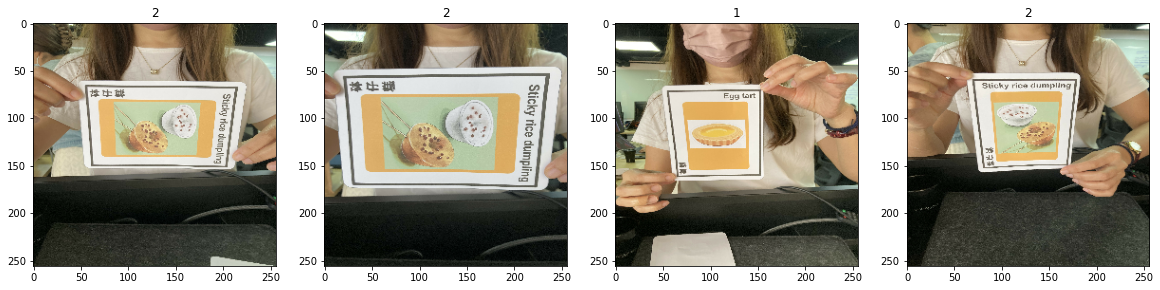

In [7]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [33]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 16 files belonging to 3 classes.
Using 13 files for training.
Found 16 files belonging to 3 classes.
Using 3 files for validation.


In [22]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.4),
    tf.keras.layers.RandomTranslation(0.05,0.05),
    tf.keras.layers.RandomContrast(0.2),
])

In [23]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
print(IMG_SIZE)
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)

(160, 160)
(160, 160, 3)


In [24]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [25]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [26]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(len(class_names))
inputs = tf.keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

In [27]:
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
history = model.fit(train_ds,
                    epochs=INITIAL_EPOCHS,
                    validation_data=val_ds)

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 4.2341 - accuracy: 0.5385 - val_loss: 6.2580 - val_accuracy: 0.3333
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 4.6204 - accuracy: 0.5385 - val_loss: 0.7376 - val_accuracy: 0.3333
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 2.2733 - accuracy: 0.6923 - val_loss: 3.8376 - val_accuracy: 0.6667
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 6.3250 - accuracy: 0.4615 - val_loss: 3.8311 - val_accuracy: 0.6667
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 4.4813 - accuracy: 0.4615 - val_loss: 0.6404 - val_accuracy: 0.6667
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 2.0047 - accuracy: 0.7692 - val_loss: 9.2842 - val_accuracy: 0.3333
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 5.6747 - accuracy: 0.6154 - val_loss: 12.0792 - val_accuracy: 0.3333
Epoch 8/100
1/1 [================

In [ ]:
tf.random.set_seed(42)

model_2=tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tf.keras.layers.Dense(1)
])

model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])